In [5]:
using Gmsh
using GridapGmsh
using Gridap
using DelimitedFiles
using KrylovKit
using LinearAlgebra
using Gridap.Fields
import Gmsh:gmsh

include("Mesh_R.jl")
include("GridapFE.jl")
include("Model.jl")

"""This part is used to define all parameters used"""
# Geometry parameters of the mesh
# Rectangular with center circle design domain
max_r = 1.0
start_r = 0.1
resol = 150.0      # Number of points per wavelength

Nri = 91
Q_list = [10, 50, 100, 1000]
Powers = zeros(Nri, length(Q_list) + 1)
Ncv1 = zeros(Int64, Nri, length(Q_list))
Ncv2 = zeros(Int64, Nri, length(Q_list))



λ = 1.0           # Wavelength
L = (max_r + 0.5) * 2           # Width of the rectangular domain
H = (max_r + 0.5) * 2           # Height of the rectangular domain
# rd = 0.7          # Radius of the design domain circle
rt = max_r + 0.2     # Radius of the target circle
dpml = 0.5        # Thickness of PML
# Characteristic length (controls the resolution, smaller the finer)
l1 = λ / resol    # Normal region
l2 = l1 / 1.0     # Design region
l3 = 2 * l1       # PML
# Physical parameters 
k = 2 * π / λ       # Wave number 
# Bloch wavevector
ω = k               # c=1
ϵ1 = 1.0            # Relative electric permittivity for material 1 (y > 0)
ϵd = 12.0           # Relative electric permittivity for design material
μ = 1.0             # Relative magnetic permeability for all materials
LHp=[L / 2, H / 2]  # Start of PML for x,y > 0
LHn=[L / 2, H / 2]  # Start of PML for x,y < 0

# PML parameters
R = 1e-10           # Tolerence for PML reflection 
σ = - 3 / 4 * log(R) / dpml / √ϵ1
############  Optimization parameters #############

# α = 1.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q
meshfile = "geometry.msh"
geo_param = RecGeometry(L, H, rt, dpml, l1, l2, l3)

MeshGenerator(geo_param, meshfile)
gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["Target"])
phys = PhysicalParameters(k, ω, ϵ1, ϵd, μ, R, σ, dpml, LHp, LHn)

N = num_free_dofs(gridap.FE_U)
O_mat = MatrixOc(phys.k, phys.ϵ1; gridap)

if isfile("ncv1.txt")
    run(`rm ncv1.txt`)
end

if isfile("ncv2.txt")
    run(`rm ncv2.txt`)
end

if isfile("power.txt")
    run(`rm power.txt`)
end

for ri = 1 : Nri
    rd = (ri - 1) * (max_r - start_r) / (Nri - 1) + start_r
    #rd = max_r
    Powers[ri, 1] = rd
    Neig = Int(ceil(ri / Nri * 25 * max_r))
    damp = 3 * rd / l1
    for qi = 1 : length(Q_list)
        α = 1.0 / (2 * Q_list[qi])
        A_mat = MatrixA(α, damp, rd; phys, gridap)
        B_mat = MatrixB(damp, rd; gridap)

        G_ii, W_raw, info = eigsolve(x -> MatrixG(x; A_mat, B_mat, O_mat), rand(ComplexF64, N), Neig, :LM; krylovdim = Neig + 5)
        Ncv1[ri, qi] = num_contributing_values(G_ii, 0.99)
        Ncv2[ri, qi] = num_contributing_values(G_ii, 0.9)
        Powers[ri, qi + 1] = sum(abs.(G_ii))
    end
    
    open("ncv1.txt", "a") do io
        writedlm(io, reshape(Ncv1[ri, :], (1, length(Q_list))))
    end

    open("ncv2.txt", "a") do io
        writedlm(io, reshape(Ncv1[ri, :], (1, length(Q_list))))
    end

    open("power.txt", "a") do io
        writedlm(io, reshape(Powers[ri, :], (1, length(Q_list)+1)))
    end
end



Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 5 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 11 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 14 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 17 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (Line)
Info    : Meshing curve 20 (Line)
Info    : Meshing curve 21 (Line)
Info    : Meshing curve 22 (Line)
Info    : Meshing curve 23 (Line)
Info    : Meshing curve 24 (Line)
Info    : Meshing curve 25 (Ci

In [12]:
ncv1 = readdlm("ncv1.txt", Int64)
ncv2 = readdlm("ncv1.txt", Int64)
power = readdlm("power.txt", Float64);

In [16]:
using GLMakie
scene, layout = layoutscene(resolution=(1200/2,1000/2))
ax = layout[1,1]=Axis(scene)
ms = 10
lin1 = lines!(ax, power[:, 1], power[:, 2], linewidth=2)
lin2 = lines!(ax, power[:, 1], power[:, 3], linewidth=2)
lin3 = lines!(ax, power[:, 1], power[:, 4], linewidth=2)
lin4 = lines!(ax, power[:, 1], power[:, 5], linewidth=2)
ax.xlabel="Design radius (λ)"
ax.ylabel="Power"
#ax.title="Optimized powers"
ax.xlabelsize=20
ax.ylabelsize=20

#Legend(layout[1,1],[lin1, lin2],["Initial", "Optimized"])
axislegend(ax, [lin1, lin2, lin3, lin4],["Q=10" "Q=50" "Q=100" "Q=1000"], position = :lt,
    orientation = :vertical)
scene
save("power.png", scene)

GLMakie.Screen(...)

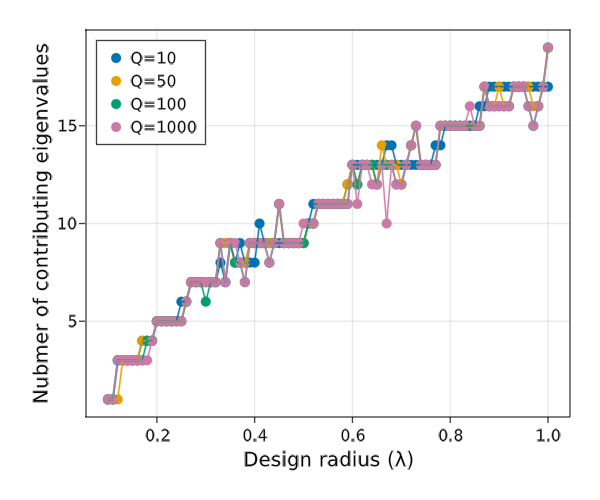

In [18]:
scene, layout = layoutscene(resolution=(1200/2,1000/2))
ax = layout[1,1]=Axis(scene)
ms = 10
lin1 = scatter!(ax, power[:, 1], Ncv1[:, 1], markersize=ms)
lin2 = scatter!(ax, power[:, 1], Ncv1[:, 2], markersize=ms)
lin3 = scatter!(ax, power[:, 1], Ncv1[:, 3], markersize=ms)
lin4 = scatter!(ax, power[:, 1], Ncv1[:, 4], markersize=ms)
lin11 = lines!(ax, power[:, 1], Ncv1[:, 1])
lin22 = lines!(ax, power[:, 1], Ncv1[:, 2])
lin33 = lines!(ax, power[:, 1], Ncv1[:, 3])
lin44 = lines!(ax, power[:, 1], Ncv1[:, 4])
ax.xlabel="Design radius (λ)"
ax.ylabel="Nubmer of contributing eigenvalues"
#ax.title="Optimized powers"
ax.xlabelsize=20
ax.ylabelsize=20

#Legend(layout[1,1],[lin1, lin2],["Initial", "Optimized"])
axislegend(ax, [lin1, lin2, lin3, lin4],["Q=10" "Q=50" "Q=100" "Q=1000"], position = :lt,
    orientation = :vertical)
save("NCV.png", scene)
scene